In [1]:
from pyspark.sql import SparkSession
import json
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict

# define an OrderedCounter for the number of speeches given by each president
class OrderedCounter(Counter, OrderedDict):
     'Counter that remembers the order elements are first encountered'

     def __init__(self, iterable=None, **kwds):
         OrderedDict.__init__(self)
         Counter.__init__(self, iterable, **kwds)

     def __repr__(self):
         return '%s(%r)' % (self.__class__.__name__, OrderedDict(self))

     def __reduce__(self):
         return self.__class__, (OrderedDict(self),)

spark  = SparkSession.builder.appName("SOU").getOrCreate()
df = spark.read.json("/project/cmsc25025/sou/speeches.json")
speeches = df.sort("year",ascending=True) # sort by year for easier processing

In [2]:
# parse the sentences, also take in year and president
speech = speeches.rdd.map(lambda x: [[x['text'].split('.'), int(x['year']), str(x['president'])]]).reduce(lambda a, b: a+b)

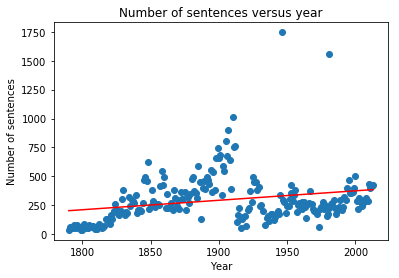

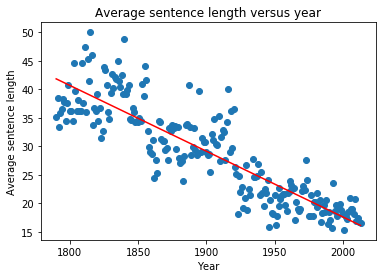

The number of sentences versus year starts fairly low and generally increases over time, though there is also a bump surrounding just after 1900. On the other hand, the average sentence length generally decreases over time. The decrease in average sentence length may reflect a change in sentence patterns, leaning more towards simple and concise sentences. Thus, more sentences are required to communicate sufficient information. In addition, the decrease in sentence length may be attribute to a shift towards spoken versus written delivery of the SOU, discussed more in the next section.


In [3]:
years = [row[1] for row in speech] # speech years
names = [row[2] for row in speech] # president names
counts = OrderedCounter(names) # counts number of speeches for each president in order

# compute the number of sentences per year
nsentences = np.array([len(speech[i][0]) for i in range(len(speech))])
# compute the number of sentences per president
psentences = []
names_reduced = [] # to associate each value of psentences with a president
start = 0
for c in counts:
    psentences.append(np.sum(nsentences[start:start+counts[c]]))
    names_reduced.append(c)
    start += counts[c]
    
# compute the average sentence length per year
avgLength = np.zeros(len(speech))
slengths = [] # sentence lengths, to be used later for quantiles
for i in range(len(speech)):
    lengths = [len(speech[i][0][j].split()) for j in range(len(speech[i][0]))]
    avgLength[i] = np.sum(lengths)/float(nsentences[i])
    slengths += lengths

# compute the regressions
m1 = (np.cov(years,nsentences) / np.var(years))[0][1] # slope for nsentences versus year
b1 = np.mean(nsentences) - m1*np.mean(years) # intercept for nsentences versus year
m2 = (np.cov(years,avgLength) / np.var(years))[0][1] # slope for avgLength versus year
b2 = np.mean(avgLength) - m2*np.mean(years) # intercept for avgLength versus year

# plot number of sentences versus year and regression
plt.figure()
plt.scatter(years,nsentences)
plt.plot(years,[m1*years[i] + b1 for i in range(len(years))],'r')
plt.xlabel('Year')
plt.ylabel('Number of sentences')
plt.title('Number of sentences versus year')
plt.show()

# plot average sentence length versus year and regression
plt.figure()
plt.scatter(years,avgLength)
plt.plot(years,[m2*years[i] + b2 for i in range(len(years))],'r')
plt.xlabel('Year')
plt.ylabel('Average sentence length')
plt.title('Average sentence length versus year')
plt.show()

print("The number of sentences versus year starts fairly low and generally increases over time, though there is also a bump surrounding just after 1900. On the other hand, the average sentence length generally decreases over time. The decrease in average sentence length may reflect a change in sentence patterns, leaning more towards simple and concise sentences. Thus, more sentences are required to communicate sufficient information. In addition, the decrease in sentence length may be attribute to a shift towards spoken versus written delivery of the SOU, discussed more in the next section.")

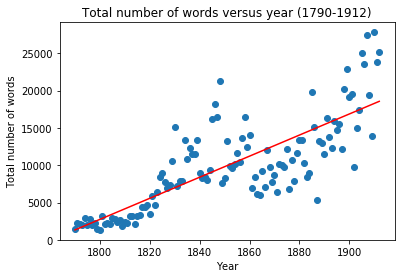

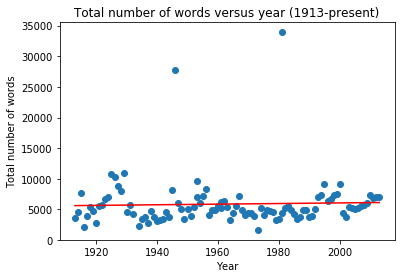

The total number of words generally increases over time between the period 1790-1912, though there are other noticable patterns such as the bump around ~1845. On the other hand, the total number of words stays fairly consistent across the years 1913-present, with two noticeable outliers. Before Woodrow Wilson (who gave his first speech in 1913), most SOU addresses were written, and following him a large percentage were spoken. This encourages a reasonable word length for speaking, which explains why the number of words from 1913-present has generally stayed consistent and at a lower number than 1790-1912. From 1790-1912 when most speeches were written, it is likely they became more verbose as the practice was more formalized and more information was included.


In [4]:
# compute total number of words for each year
nwords = np.multiply(nsentences,avgLength)
splitIndex = years.index(1913) # split years by 1790 - 1912, 1913 - present

# compute the regressions
m1 = (np.cov(years[:splitIndex],nwords[:splitIndex]) / np.var(years[:splitIndex]))[0][1] # 1790 - 1912 slope
b1 = np.mean(nwords[:splitIndex]) - m1*np.mean(years[:splitIndex]) # 1790 - 1912 intercept
m2 = (np.cov(years[splitIndex:],nwords[splitIndex:]) / np.var(years[splitIndex:]))[0][1] # 1913 - present slope
b2 = np.mean(nwords[splitIndex:]) - m2*np.mean(years[splitIndex:]) # 1913 - present intercept

# plot total number of words versus year (1790 - 1912) and regression
plt.figure()
plt.scatter(years[:splitIndex],nwords[:splitIndex])
plt.plot(years[:splitIndex],[m1*years[i] + b1 for i in range(len(years[:splitIndex]))],'r')
plt.xlabel('Year')
plt.ylabel('Total number of words')
plt.title('Total number of words versus year (1790-1912)')
plt.show()

# plot total number of words versus year (1913 - present) and regression
plt.figure()
plt.scatter(years[splitIndex:],nwords[splitIndex:])
plt.plot(years[splitIndex:],[m2*years[i] + b2 for i in range(splitIndex,len(years))],'r')
plt.xlabel('Year')
plt.ylabel('Total number of words')
plt.title('Total number of words versus year (1913-present)')
plt.show()

print("The total number of words generally increases over time between the period 1790-1912, though there are other noticable patterns such as the bump around ~1845. On the other hand, the total number of words stays fairly consistent across the years 1913-present, with two noticeable outliers. Before Woodrow Wilson (who gave his first speech in 1913), most SOU addresses were written, and following him a large percentage were spoken. This encourages a reasonable word length for speaking, which explains why the number of words from 1913-present has generally stayed consistent and at a lower number than 1790-1912. From 1790-1912 when most speeches were written, it is likely they became more verbose as the practice was more formalized and more information was included.")

In [5]:
# find president with longest and shortest sentences on average
# compute average sentence length for each president
totalAvgLength = [0]*len(psentences) # average sentence length across all of a president's speeches
start = 0
for i,num in enumerate(psentences):
    totalAvgLength[i] = (np.sum(slengths[start:start+num]))/float(num)
    start += num
longIndex = totalAvgLength.index(max(totalAvgLength))
shortIndex = totalAvgLength.index(min(totalAvgLength))
print "Considering the sentences across all of a given president's SOU addresses, %s has the longest sentences on average across their speeches and %s has the shortest." % (names_reduced[longIndex],names_reduced[shortIndex])

# compute the median, 25% and 75% quantiles across all Presidents
slengths = np.array(slengths)
quant50 = np.percentile(slengths,50)
quant25 = np.percentile(slengths,25)
quant75 = np.percentile(slengths,75)
print "Across all presidents, %d words is the median sentence length, %d is the 25th quantile sentence length, and %d is the 75th quantile sentence length." % (quant50,quant25,quant75)

# find overall longest and shortest sentence
# determine the speech in which these sentences occur
# and the index of the sentence within that speech
maxIndex = np.argmax(slengths)
minIndex = np.argmin(slengths)
nsentences_cum = np.cumsum(nsentences) - 1
for i in range(1,len(nsentences_cum)):
    if minIndex > (nsentences_cum[i-1]) and minIndex <= (nsentences_cum[i]):
        print('s1 changes')
        s1 = i # speech index of shortest sentence ever
        s1_index = minIndex - (nsentences_cum[i-1]) - 1 # sentence index within that speech
    if maxIndex > (nsentences_cum[i-1]) and maxIndex <= (nsentences_cum[i]):
        s2 = i # speech index of longest sentence ever
        s2_index = maxIndex - (nsentences_cum[i-1]) - 1 # sentence index within that speech
        break

print "The longest sentence in an SOU is sentence %d of %s's address, with %d words: %s" % (s2_index,names[s2],slengths[maxIndex],speech[s2][0][s2_index])
print "The shortest sentence in an SOU is sentence %d of %s's address, with %d words: %s" % (s1_index,names[s1],slengths[minIndex],speech[s1][0][s1_index])



Considering the sentences across all of a given president's SOU addresses, James Madison has the longest sentences on average across their speeches and George Bush has the shortest.
Across all presidents, 23 words is the median sentence length, 14 is the 25th quantile sentence length, and 36 is the 75th quantile sentence length.
s1 changes
The longest sentence in an SOU is sentence 15 of Jimmy Carter's address, with 597 words:   

Over the past 48 months, clear progress has been made in solving the challenges we found in January of 1977:  

 almost all of our comprehensive energy program have been enacted, and the Department of Energy has been established to administer the program;  

 confidence in the government's integrity has been restored, and respect for the government's openness and fairness has been renewed;  

 the government has been made more effective and efficient: the Civil Service system was completely reformed for the first time this century; 14 reorganization initia